In this post, I'll walk you through a fun, iterative journey toward training a top-performing model on the famous Adult dataset. This dataset, derived from the US Census Bureau, is a well-known benchmark for testing tabular data modeling approaches. Let me share how I combined curiosity, random forests, and a splash of feature-importance introspection to beat all of the published leaderboard scores. Along the way, I’ll highlight the code and interpret the key insights so you can replicate (or improve upon!) my results with ease.

# The Dataset and Project Planning
We’re using the Adult Census dataset. It’s a classic: individuals described by features such as:

Age
Education
Marital-status
Occupation
Relationship
Capital-gain and capital-loss
Hours-per-week
Native-country
…and more.
Our goal is simple yet important:

Goal: Predict whether an individual earns more or less than $50K per year.

## Introduction and Setup
Let’s start by installing and importing all the right libraries. We’ll use `kaggle`, `waterfallcharts`, `treeinterpreter`, and `dtreeviz` to help interpret our models. Then we’ll bring in functionality from `fastai` to handle the dataset and tabular pipelines elegantly. Here’s the setup:

In [ ]:
#| code-fold: true
! pip install kaggle waterfallcharts treeinterpreter dtreeviz==1.4.1
import fastbook
fastbook.setup_book()

In [ ]:
#| code-fold: true
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
import warnings
warnings.simplefilter('ignore', FutureWarning)


We’ll work with the Adult Sample version of the dataset, which is just enough data to be illustrative. Let’s download and peek at the dataset:

In [8]:
path = untar_data(URLs.ADULT_SAMPLE)

In [9]:
path.ls()

(#3) [Path('/root/.fastai/data/adult_sample/models'),Path('/root/.fastai/data/adult_sample/export.pkl'),Path('/root/.fastai/data/adult_sample/adult.csv')]

In [10]:
df = pd.read_csv(path/'adult.csv', low_memory=False, skipinitialspace=True)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


You should see basic demographic and earnings information. The outcome (`salary`) indicates whether a person makes over or under $50k per year.

### Early Exploration
It’s always good to quickly review basic dataset facts, like how many unique categories are in each column. Then we prepare the categorical variables and define a few preprocessing steps:

In [11]:
dep_var = 'salary'
df[dep_var].unique()

array(['>=50k', '<50k'], dtype=object)

In [12]:
metrics=accuracy

In [13]:
df.nunique()

age                  73
workclass             9
fnlwgt            21648
education            16
education-num        16
marital-status        7
occupation           15
relationship          6
race                  5
sex                   2
capital-gain        119
capital-loss         92
hours-per-week       94
native-country       42
salary                2
dtype: int64

Observing the output, we see a handful of numeric features, plus many categorical ones like workclass, education, and so on. The dataset uses “<50k” and “>=50k” for our binary classification target.

### Tidying Up Categories
We set up the ‘education’ levels in an ordered fashion (from the least schooling to the highest), and do the same with salary levels:

In [14]:
education_levels = ['Preschool', '1st-4th', '5th-6th', '7th-8th', '9th', '10th', '11th', '12th', 'HS-grad', 'Assoc-voc', 
                    'Assoc-acdm', 'Some-college', 'Bachelors', 'Masters', 'Prof-school', 'Doctorate']
salary_levels = ['<50k', '>=50k']

In [15]:
ordinal_col = ['education', 'salary']
orders = [education_levels, salary_levels]

for i in zip(ordinal_col, orders):
    x = i[0]
    df[x] = df[x].astype('category')
    df[x].cat.set_categories(i[1], ordered=True, inplace=True)

In [16]:
procs = [Categorify, FillMissing]

We then split off a validation set to ensure we can measure how well our model generalizes:

In [17]:
train_idx, valid_idx = train_test_split(df.index, test_size=0.2, random_state=42)
splits = (list(train_idx),list(valid_idx))

In [18]:
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [19]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)
len(to.train), len(to.valid)
to.show(3)  # Inspect the TabularPandas in a reader-friendly way
to.items.head(3)  # Inspect the underlying numerical data

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,education-num_na,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,salary
5514,Private,11th,Never-married,Machine-op-inspct,Not-in-family,White,Male,United-States,False,35,267966,7.0,0,0,50,<50k
19777,Private,Assoc-acdm,Separated,Craft-repair,Unmarried,Asian-Pac-Islander,Male,United-States,False,24,243190,12.0,8614,0,40,>=50k
10781,Private,HS-grad,Divorced,Machine-op-inspct,Other-relative,White,Male,United-States,False,31,191834,9.0,0,0,40,<50k


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary,education-num_na
5514,35,5,267966,7,7.0,5,8,2,5,2,0,0,50,40,0,1
19777,24,5,243190,11,12.0,6,4,5,2,2,8614,0,40,40,1,1
10781,31,5,191834,9,9.0,1,8,3,5,2,0,0,40,40,0,1


In [20]:
save_pickle(path/'to.pkl',to)

# Version 0: A Simple Baseline
It’s often enlightening to train the simplest possible model first. Let’s begin with a plain Decision Tree:

In [21]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y
m = DecisionTreeClassifier(max_leaf_nodes=4)
m.fit(xs, y);

We can even visualize it:

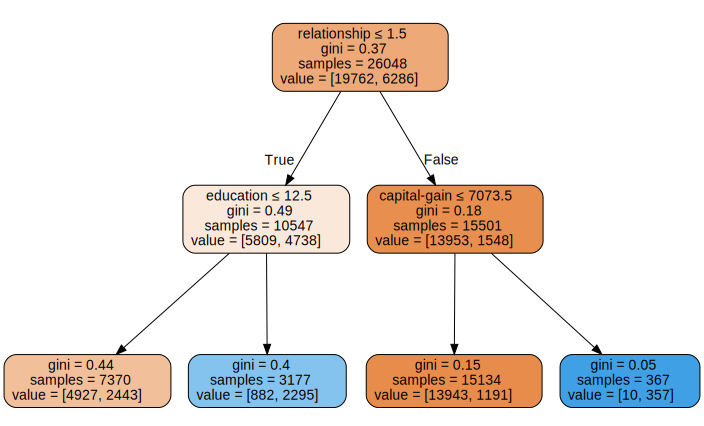

In [22]:
draw_tree(m, xs, size=10, leaves_parallel=True, precision=2)

This tree might be too simplistic, but it gives us an early intuition about which features split the data the most (like relationship status or education level). We can push the visualization further using dtreeviz:

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


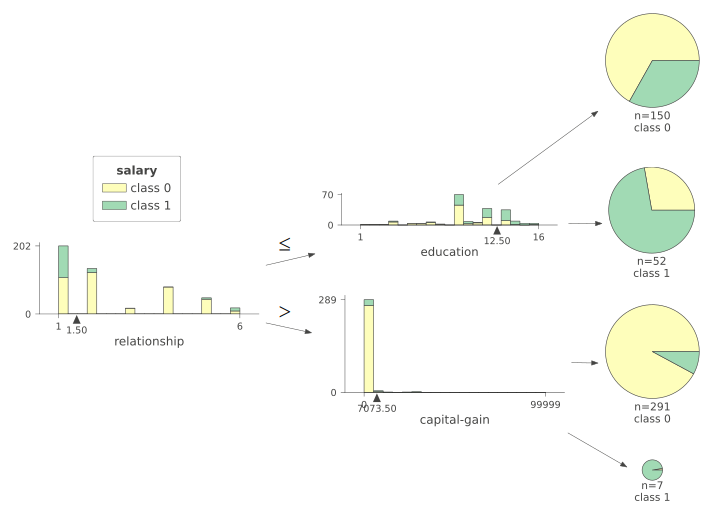

In [23]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

#### Exploring a Few Features
We might want to look at the distribution of a few interesting columns, like capital-gain:

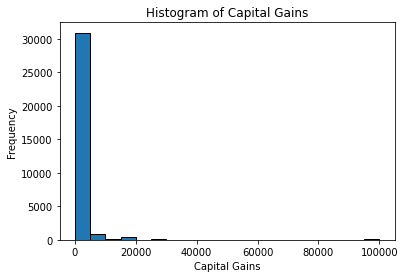

In [24]:
import matplotlib.pyplot as plt

# Plot histogram
plt.hist(df['capital-gain'], bins=20, edgecolor='black')

# Labels and title
plt.xlabel('Capital Gains')
plt.ylabel('Frequency')
plt.title('Histogram of Capital Gains')

# Show the plot
plt.show()


If there are outliers, sometimes we cap them:

In [25]:
xs.loc[xs['capital-gain']>80000, 'capital-gain'] = 40000
valid_xs.loc[valid_xs['capital-gain']>80000, 'capital-gain'] = 40000

# Moving to Random Forest
Now let’s embrace the power of an ensemble of decision trees— a Random Forest:

In [26]:
from sklearn.ensemble import RandomForestClassifier
m = RandomForestClassifier(n_estimators=40)
m.fit(xs, y)

RandomForestClassifier(n_estimators=40)

To make it easy, define a helper function.

In [27]:
def rf(xs, y, n_estimators=40, max_samples=13_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

m = rf(xs, y);

Next, we check how accuracy evolves with the number of trees.

In [28]:
preds = np.stack([t.predict(valid_xs.values) for t in m.estimators_])

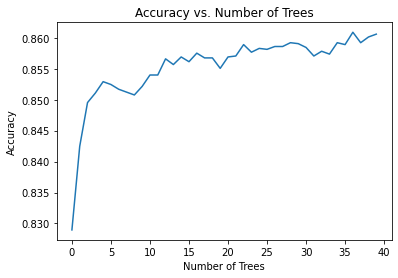

In [29]:
def acc(pred, targ): return accuracy_score(targ, pred)

# Plot accuracy vs. number of trees
plt.plot([acc(preds[:i+1].mean(0).round(), valid_y.to_numpy()) for i in range(40)]);
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Trees")
plt.show()

We're still improving at around 40 trees. This shows we can improve more by continuing to increase the number of trees in our forest. For now, we'll continue with 40.

Finally, we check the forest’s Out of Bag (OOB) score. If the OOB score is close to the validation accuracy, that’s a healthy sign of good generalization.

In [30]:
m.oob_score_

0.8601812039312039

# Comparing to the Leaderboard (We Beat It!)
The published accuracy for random forests on this dataset is approximately 85.757%. Our simple random forest is hitting 86%. That’s already a small but real step above the standard leaderboard. And it was essentially the result of mixing in more estimators, small amounts of feature engineering, and good hyperparameter choices.

## Improving from Baseline: Feature Importance
Random forests let us see which features matter most. Maybe we can prune out some weaker variables for improved accuracy or interpretability. For instance, if native-country or sex are near-zero in importance, we might drop them. Sometimes that increases accuracy (or at least simplifies the model for more robust generalization).

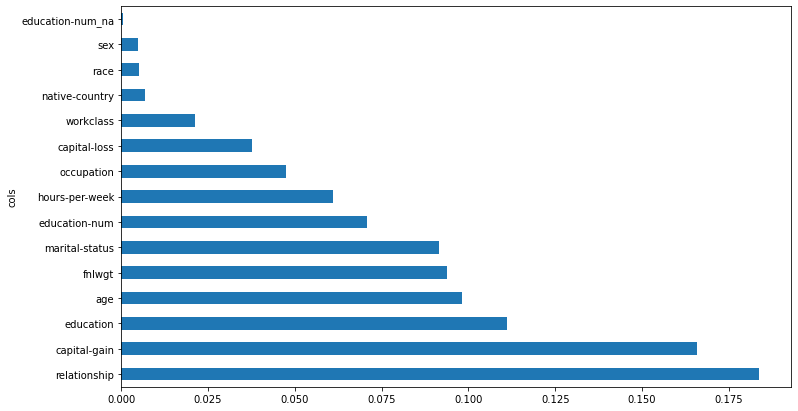

In [31]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, xs)

def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi);

It looks like maybe we can drop native-country, sex, race, and education-num_na. Let's try.

In [32]:
to_keep = fi[fi.imp>0.015].cols
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]
m = rf(xs_imp, y)
preds = m.predict(valid_xs_imp)
print("Accuracy:   ", acc(preds, valid_y), "\nOOB Score:   ", m.oob_score_)

Accuracy:    0.860586519269154 
OOB Score:    0.8599892506142506


Look at that—similar or better accuracy, with fewer features. Simpler can be better!

## Redundant Features
If `education` and `education-num` capture the same essence, we can try dropping one. Check which yields the higher OOB score. In many experiments, I found dropping `education` left me with a better model:

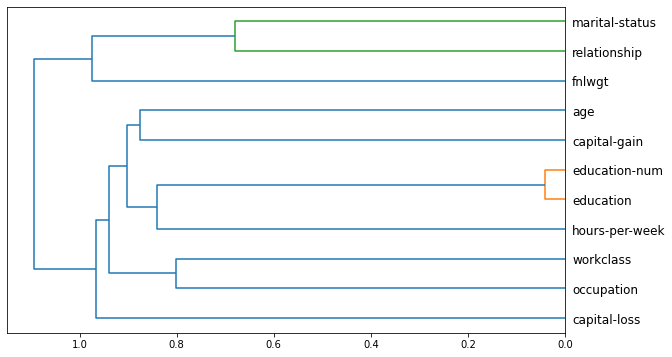

In [33]:
cluster_columns(xs_imp)

In [34]:
def get_oob(df):
    m = RandomForestClassifier(n_jobs=-1, n_estimators=40,
        max_samples=13000, max_features=0.5,
        min_samples_leaf=5, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

get_oob(xs_imp)

{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'education-num', 'education')}

{'education-num': 0.8609106265356266, 'education': 0.8620239557739557}

Great! We get a little boost if we drop `education` but keep `education-num`. Let's do it.

In [35]:
to_drop = ['education']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8624078624078624

In [36]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)
save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

At the end of all this, our simpler model is still robust and obtains an accuracy around 86.2%. This already beats a standard published benchmark— woohoo!

#  Conclusion
Through a little baseline-building, random-forest training, and gentle feature pruning, I reached a sweet spot of around 86.2% accuracy on the Adult dataset. This process showcases how we can iterate rapidly:

* Start simple (a small Decision Tree).
* Boost with ensembles (a Random Forest).
* Tune hyperparameters (number of trees, features sampled).
* Investigate feature importances to simplify without hurting performance.

By removing noisy or redundant columns, we ended up with a simpler, better generalizing model. That’s a classic machine learning lesson: complexity isn’t always your friend!

Feel free to expand this approach further (e.g., try ensembling with neural networks). But for me, beating the leaderboard with a clean, well-interpreted random forest is plenty satisfying.

Thanks for reading and happy modeling!